In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dropout, Dense, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os
import cv2
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [29]:
# Load the annotations CSV file into a Pandas DataFrame
df = pd.read_csv('../input/aquatrash/annotations.csv')

# Set the path to the directory containing the images for the task
imagefolder = '../input/aquatrash/Images'

# Extract the unique class names from the 'class_name' column of the DataFrame
classes = np.unique(df['class_name'])

In [30]:
df['class_name'].value_counts()

plastic    191
metal      118
paper      116
glass       44
Name: class_name, dtype: int64

In [31]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(df['class_name'])

LabelBinarizer()

In [32]:
# Calculate class weights based on the distribution of classes in the dataset
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(df['class_name']), y=df['class_name'])
# Convert the class weights to a dictionary format
class_weights_dict = dict(enumerate(class_weights))
# Print the class weights
print(class_weights_dict)

# Split the data into training, validation, and test sets
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=True)
train_data, valid_data = train_test_split(train_data, test_size=0.2, shuffle=True)

{0: 2.664772727272727, 1: 0.9936440677966102, 2: 1.0107758620689655, 3: 0.6138743455497382}


In [33]:
def prepare_data(data):
    # Initialize lists to store images, coordinates, and labels
    images = []
    coords = []
    labels = []
    
    # Iterate over each row in the DataFrame
    for row in data.iloc:
        # Extract the image filename, bounding box coordinates, and label from the row
        image_name, start_x, start_y, end_x, end_y, label = row
        
        # Load the image and resize it to (224, 224)
        image = tf.keras.utils.load_img(f'{imagefolder}/{image_name}')
        image = tf.keras.utils.img_to_array(image)
        height, width = image.shape[:2]
        image = tf.image.resize(image, (224, 224))
        
        # Convert bounding box coordinates to absolute values
        abs_start_x = float(start_x) / width
        abs_start_y = float(start_y) / height
        abs_end_x = float(end_x) / width
        abs_end_y = float(end_y) / height
        
        # Append the image, coordinates, and label to their respective lists
        images.append(image)
        coords.append((abs_start_x, abs_start_y, abs_end_x, abs_end_y))
        labels.append(label)
    
    # Convert the images, coordinates, and labels to NumPy arrays
    images = np.array(images, dtype='float32') / 255
    coords = np.array(coords, dtype='float32')
    labels = label_binarizer.transform(labels)
    
    return images, coords, labels

In [8]:
#model  = YOLO("yolov8n.pt")


100%|██████████| 6.23M/6.23M [00:00<00:00, 67.5MB/s]


In [34]:
# Load the VGG19 model with pre-trained weights, excluding the top classification layer
vgg = tf.keras.applications.vgg19.VGG19(
    include_top=False,
    input_shape=(224, 224, 3)
)

# Set the pre-trained weights of the VGG19 model to be non-trainable
vgg.trainable = False

# Create a flatten layer to convert the output of the VGG19 model to a 1D tensor
flatten = Flatten()(vgg.output)

# Create a branch for bounding box regression
bbox = Dropout(0.5)(flatten)
bbox = Dense(512, activation='relu')(bbox)
bbox = Dense(128, activation='relu')(bbox)
bbox = Dropout(0.5)(bbox)
bbox_result = Dense(4, activation='sigmoid', name='bbox_result')(bbox)

# Create a branch for classification
label = Dropout(0.5)(flatten)
label = Dense(512, activation='relu')(label)
label = Dense(256, activation='relu')(label)
label = Dropout(0.5)(label)
label_result = Dense(len(label_binarizer.classes_), activation='softmax', name='label_result')(label)

# Create a Keras model that takes an input image and outputs both the bounding box and label predictions
model = Model(vgg.input, [bbox_result, label_result])

In [35]:
# Define the loss functions for each output branch of the model
losses = {
    "label_result": "categorical_crossentropy",
    "bbox_result": "mean_squared_error",
}

# Set the weight of each output branch in the overall loss function
loss_weights = {
    "label_result": 1.0,
    "bbox_result": 1.0
}

# Compile the model with the defined loss functions, optimizer, and evaluation metrics
model.compile(loss=losses, optimizer=Adam(0.00007), metrics=["accuracy"])

In [36]:
# Call the prepare_data function with the train_data input and assign the outputs to variables
train_images, train_coords, train_labels = prepare_data(train_data)

# Call the prepare_data function with the test_data input and assign the outputs to variables
test_images, test_coords, test_labels = prepare_data(test_data)

In [38]:
# Create a dictionary of training targets with label_result and bbox_result keys,
# and corresponding values of train_labels and train_coords
train_targets = {
    "label_result": train_labels,
    "bbox_result": train_coords,
}

# Create a dictionary of test targets with label_result and bbox_result keys,
# and corresponding values of test_labels and test_coords
test_targets = {
    "label_result": test_labels,
    "bbox_result": test_coords,
}

In [39]:
#fitting the model
history = model.fit(
    train_images, train_targets,
    validation_data=(test_images, test_targets),
    epochs=100,
    batch_size=16
)

Epoch 1/100
19/19 [==============================] - 14s 236ms/step - loss: 1.7763 - bbox_result_loss: 0.0703 - label_result_loss: 1.7060 - bbox_result_accuracy: 0.4667 - label_result_accuracy: 0.2700 - val_loss: 1.1569 - val_bbox_result_loss: 0.0307 - val_label_result_loss: 1.1262 - val_bbox_result_accuracy: 0.4681 - val_label_result_accuracy: 0.5426
Epoch 2/100
19/19 [==============================] - 1s 70ms/step - loss: 1.4073 - bbox_result_loss: 0.0392 - label_result_loss: 1.3680 - bbox_result_accuracy: 0.5067 - label_result_accuracy: 0.3667 - val_loss: 1.2483 - val_bbox_result_loss: 0.0275 - val_label_result_loss: 1.2208 - val_bbox_result_accuracy: 0.5851 - val_label_result_accuracy: 0.4255
Epoch 3/100
19/19 [==============================] - 1s 69ms/step - loss: 1.2994 - bbox_result_loss: 0.0335 - label_result_loss: 1.2659 - bbox_result_accuracy: 0.4967 - label_result_accuracy: 0.4067 - val_loss: 1.2811 - val_bbox_result_loss: 0.0274 - val_label_result_loss: 1.2536 - val_bbox_re

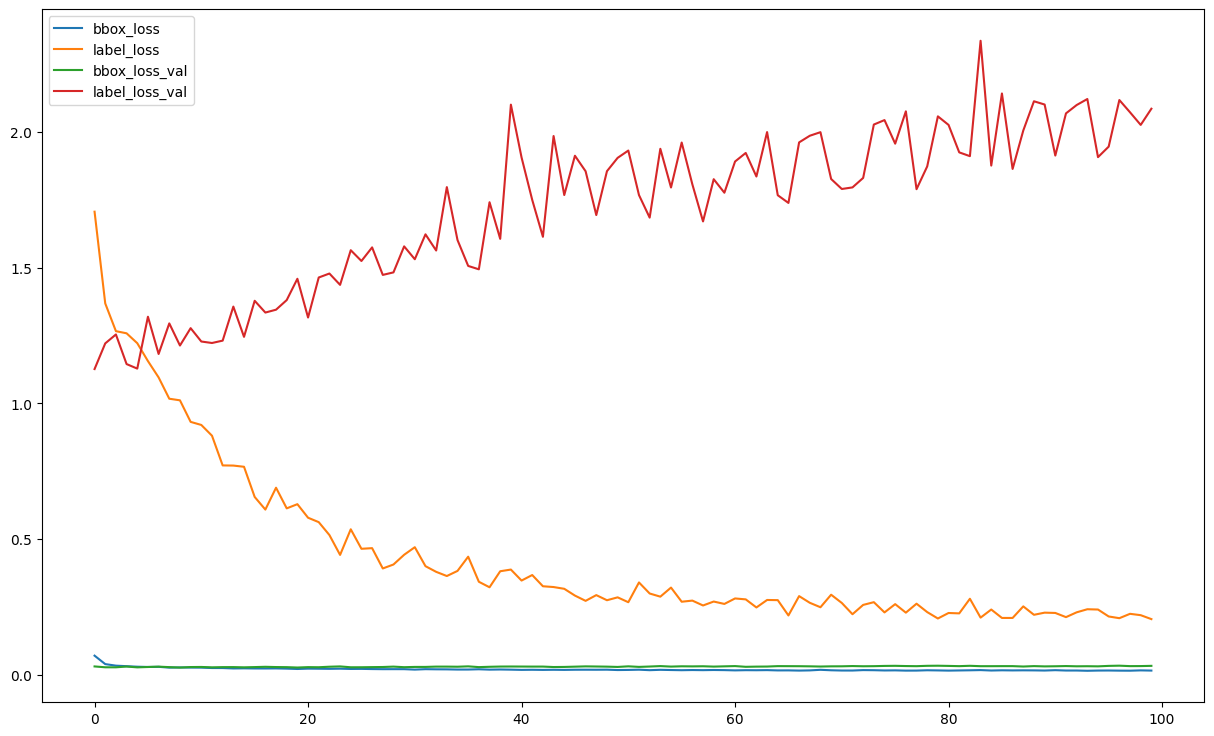

In [40]:
plt.figure(figsize=(15, 9))
# Plot the training loss for the bounding box regression and classification separately
plt.plot(history.history['bbox_result_loss'], label='bbox_loss')
plt.plot(history.history['label_result_loss'], label='label_loss')

# Plot the validation loss for the bounding box regression and classification separately
plt.plot(history.history['val_bbox_result_loss'], label='bbox_loss_val')
plt.plot(history.history['val_label_result_loss'], label='label_loss_val')

# Add a legend to the plot and show it
plt.legend()
plt.show()

In [41]:
 valid_images, valid_coords, valid_labels = prepare_data(valid_data)


In [42]:
(box_pred, label_pred) = model.predict(valid_images)


3/3 [==============================] - 5s 624ms/step


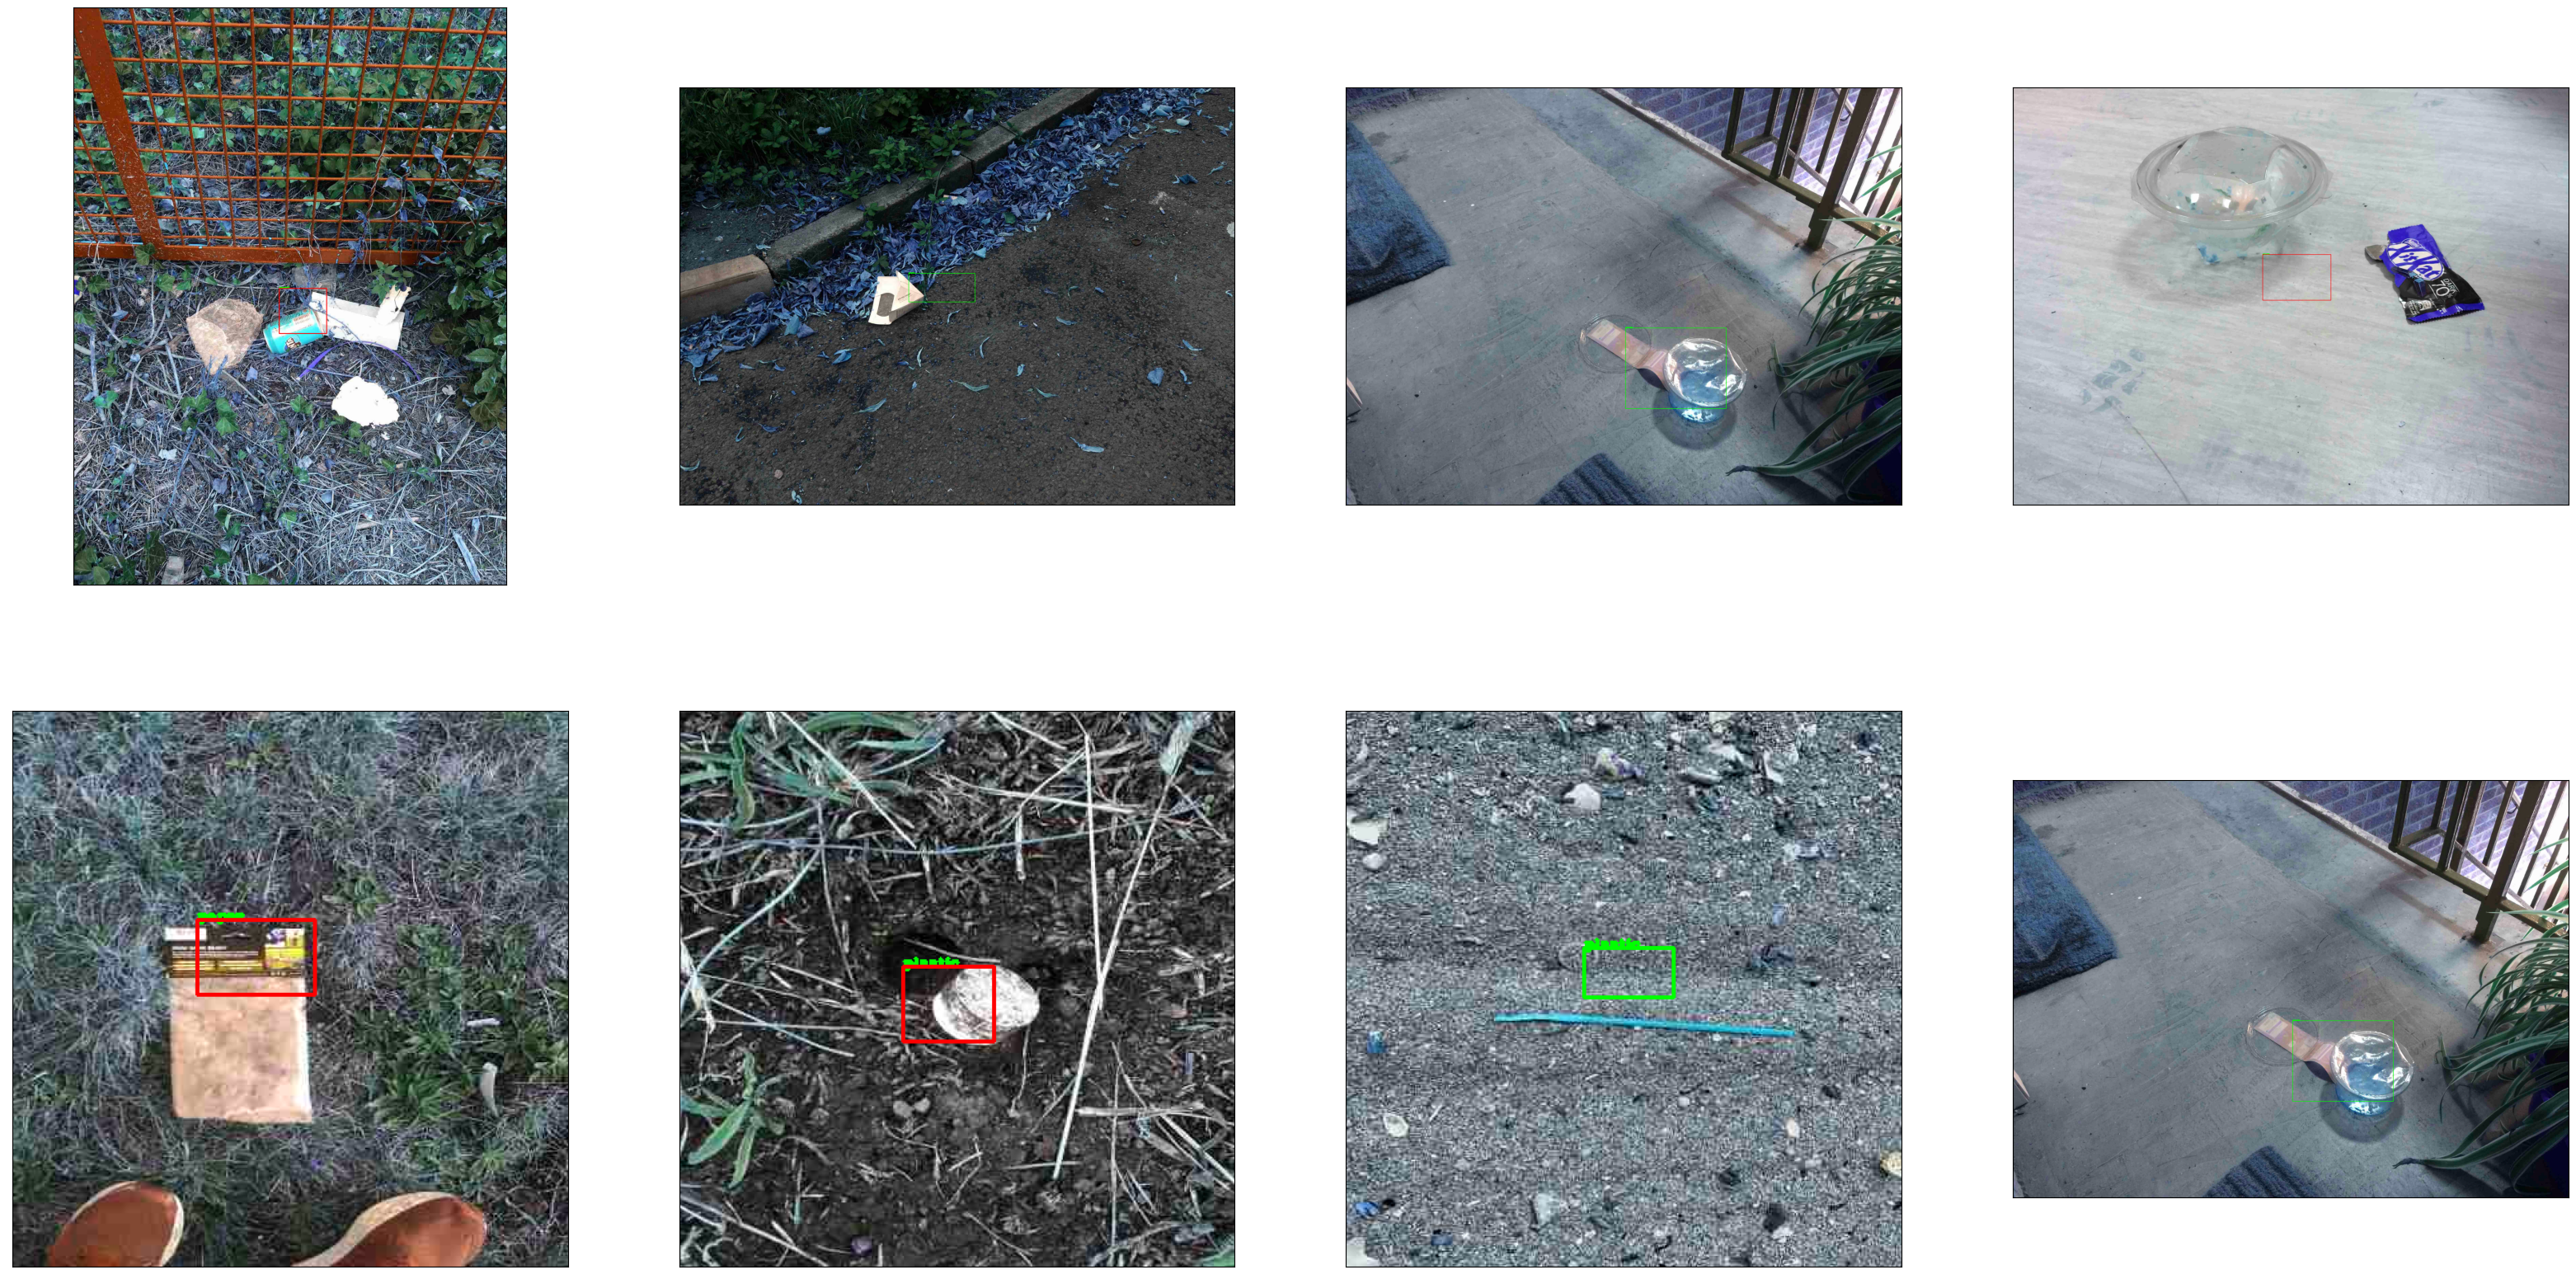

In [48]:
#Create a figure with a size of 40x20 inches
plt.figure(figsize=(40, 20))

# Loop through 8 images
for i in range(1, 9):
    # Create a subplot with 2 rows and 4 columns, and set the current plot to the ith subplot
    plt.subplot(2, 4, i)
    
    # Choose a random index from the validation set
    rand_idx = random.randint(0, len(valid_images)-1)
    
    # Load the corresponding image from the file system using the image name from the validation set
    image = cv2.imread(imagefolder+'/'+valid_data['image_name'].iloc[rand_idx])
    
    # Get the predicted bounding box coordinates and labels for the current image
    (start_x, start_y, end_x, end_y) = box_pred[rand_idx]
    pred_label = classes[np.argmax(label_pred[rand_idx])]
    true_label = classes[np.argmax(valid_labels[rand_idx])]
    
    # Convert the predicted bounding box coordinates from normalized values to pixel values
    start_x = int(start_x*image.shape[1])
    start_y = int(start_y*image.shape[0])
    end_x = int(end_x*image.shape[1])
    end_y = int(end_y*image.shape[0])
    
    # Set the color of the bounding box to green if the predicted label matches the true label, and red otherwise
    color = (0, 255, 0) if true_label==pred_label else (255, 0, 0)
    
    # Add the predicted label as text to the image, and draw the bounding box with the appropriate color
    cv2.putText(image, pred_label, (start_x, start_y), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, (0, 255, 0), 2)
    cv2.rectangle(image, (start_x, start_y), (end_x, end_y), color, 2)
    
    # Remove the tick marks from the x and y axes, and display the image
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)